In [124]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline

In [126]:
path1 ="/content/drive/MyDrive/BX-CSV-Dump/BX-Books.csv"
books=pd.read_csv(path1, sep=';', error_bad_lines=False, encoding="latin-1")
path2 ="/content/drive/MyDrive/BX-CSV-Dump/BX-Book-Ratings.csv"
ratings=pd.read_csv(path2, sep=';', error_bad_lines=False, encoding="latin-1")
path3 ="/content/drive/MyDrive/BX-CSV-Dump/BX-Users.csv"
users=pd.read_csv(path3, sep=';', error_bad_lines=False, encoding="latin-1")


b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:27

In [127]:
counts1 = ratings['User-ID'].value_counts()
ratings = ratings[ratings['User-ID'].isin(counts1[counts1 >= 200].index)]
counts = ratings['Book-Rating'].value_counts()
ratings = ratings[ratings['Book-Rating'].isin(counts[counts >= 100].index)]

In [128]:
df = pd.merge(ratings, books, on='ISBN')
columns = ['Image-URL-M', 'Image-URL-S']
df = df.drop(columns, axis=1)


In [129]:
df = df.dropna(axis = 0, subset = ['Book-Title'])

book_ratingCount = (df.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().rename(columns = {'Book-Rating': 'totalRatingCount'}) [['Book-Title', 'totalRatingCount']] )


In [130]:
rating_with_totalRatingCount = df.merge(book_ratingCount, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')


In [131]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [132]:
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= 50').reset_index()
rating_popular_book=rating_popular_book.drop(['index'], axis=1)

In [133]:
from scipy.sparse import csr_matrix
rating_popular_book = rating_popular_book.drop_duplicates(['User-ID', 'Book-Title'])
rating_pivot = rating_popular_book.pivot(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
rating_matrix = csr_matrix(rating_pivot.values)

from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [134]:
query_index = np.random.choice(rating_pivot.shape[0])
#print(query_index)
distances, indices = model_knn.kneighbors(rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

In [135]:
rating_pivot.index[query_index]


'Acceptable Risk'

Recommendations for "Acceptable Risk":

1: Chromosome 6


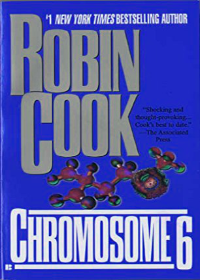

http://images.amazon.com/images/P/0425161242.01.LZZZZZZZ.jpg
2: Invasion


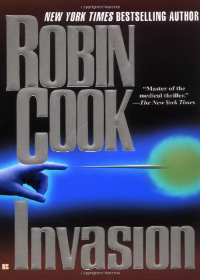

http://images.amazon.com/images/P/0425155404.01.LZZZZZZZ.jpg
3: Toxin


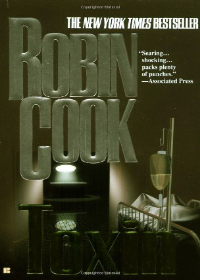

http://images.amazon.com/images/P/0425166619.01.LZZZZZZZ.jpg
4: Watchers


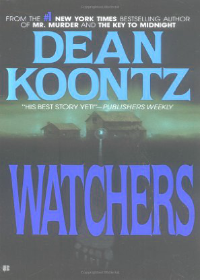

http://images.amazon.com/images/P/0425107469.01.LZZZZZZZ.jpg
5: Dolores Claiborne


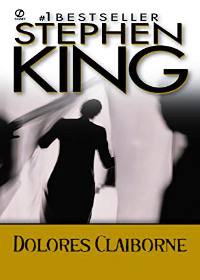

http://images.amazon.com/images/P/0451177096.01.LZZZZZZZ.jpg


In [136]:
from skimage import io
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for "{0}":\n'.format(rating_pivot.index[query_index]))
    else:
        print('{0}: {1}'.format(i, rating_pivot.index[indices.flatten()[i]]))
        url=rating_popular_book.loc[rating_popular_book.index[rating_popular_book['Book-Title']==rating_pivot.index[indices.flatten()[i]]][0]]['Image-URL-L']
        img=io.imread(url)
        img=cv2.resize(img,(200,280))
        cv2_imshow(img)
        print(url)